<a href="https://colab.research.google.com/github/Akowsor15/Project-3-ChatGPT/blob/Code/ChatGPT_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/mpwolke/chatgpt-tweets/notebook#Show-the-output-of-the-model

In [ ]:
import re
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from tqdm.auto import tqdm
import matplotlib.style as style
style.use('fivethirtyeight')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import geopy
import tweepy
import csv
import json
import time


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/chatgpt_tweets.csv', encoding='utf8')
df.tail(2)
#/content/drive/MyDrive/chatgpt_tweets.csv
#Tweets from 4 months

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
274656,Jack Brewster,Jan 2023 directed NewsGuard,New York,Media and News,2012-05-05 18:20:24:00:00,2267,2349,142,False,2023-25-03 20:30:10+00:00,"['Newsguard,ChatGPT']",Twitter web app
274657,BusinessEdge.CO,ChatGPT plugin,Waterlooville,Newsletter Tech,2022-10-10 19:13:24:00:00,1266,2549,114,False,2023-25-03 16:25:10+00:00,"['TechSAAS, AI']",Twitter web app


In [ ]:
# checking dataset

print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n",df.nunique())

Rows     :  274658
Columns  :  12

Features : 
 ['user_name', 'text', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'hashtags', 'source']

Missing values :   149565

Unique values :  
 user_name           124605
text                271276
user_location        30521
user_description    124267
user_created        126561
user_followers       30798
user_friends         13762
user_favourites      41915
user_verified           36
date                262332
hashtags             63808
source                 847
dtype: int64


#Users and Followers

In [ ]:
#Not working

#print(int(len(df[df['user_followers'] < 1000])), 'users with less than 1000 followers')
#print(len(df[df['user_followers'] > 1000]), 'userss with more than 1000 followers')

#Users with more Followers

In [ ]:
# User with the most followers
#Not working
#df[df['user_followers'] == df['user_followers'].max()]['user_name'].iloc[0]

#Followers

In [ ]:
#hin = df[(df['user_name']=="The Hindu"
        # )].reset_index(drop=True)
#hin.head()
Wang = df[(df['user_name']=="Wang"
         )].reset_index(drop=True)
Wang.head()


,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Wang,ChatGPT,Sillicon Valley,Digital transformation,Apr-08,141.6k,103.6k,132,FALSE,03/04/2023,['ChatGPT'],Twitter web app
1,Wang,The explosion of ChatGPT and the fall of Bard ...,NaN,NaN,2011-07-15 16:15:48+00:00,52,175,353,FALSE,2023-02-09 09:56:10+00:00,NaN,Twitter Web App


#Users with more friends

In [ ]:
# video with the most comments
#df[df['user_friends'] == df['user_friends'].max()]['user_name'].iloc[0]

#Cleaning Functions

In [ ]:
def remove_line_breaks(text):
    text = text.replace('\r', ' ').replace('\n', ' ')
    return text

#remove punctuation
def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")  # such as __NAME__, __LINK__
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    '''Escape all the characters in pattern except ASCII letters and numbers'''
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(" ", token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)
def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def lowercase(text):
    text_low = [token.lower() for token in word_tokenize(text)]
    return ' '.join(text_low)

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    text = " ".join([word for word in word_tokens if word not in stop])
    return text

#remobe one character words
def remove_one_character_words(text):
    '''Remove words from dataset that contain only 1 character'''
    text_high_use = [token for token in word_tokenize(text) if len(token)>1]      
    return ' '.join(text_high_use)   
    #%%
# Stemming with 'Snowball stemmer" package
def stem(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in word_tokenize(text)]        
    return ' '.join(text_stemmed)

def lemma(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in word_tokens])       
    return ' '.join(text_lemma)


#break sentences to individual word list
def sentence_word(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens
#break paragraphs to sentence token 
def paragraph_sentence(text):
    sent_token = nltk.sent_tokenize(text)
    return sent_token    
    def tokenize(text):
     """Return a list of words in a text."""
    return re.findall(r'\w+', text)

def remove_numbers(text):
    no_nums = re.sub(r'\d+', '', text)
    return ''.join(no_nums)



def clean_text(text):
    _steps = [
    remove_line_breaks,
    remove_one_character_words,
    remove_special_characters,
    lowercase,
    remove_punctuation,
    remove_stopwords,
    stem,
    remove_numbers
    ]
    for step in _steps:
        text=step(text)
    return text   
#%%

In [ ]:
df["text"] = df["text"].astype(str)
df["text"] = [x.replace(':',' ') for x in df["text"]]

In [ ]:
 df['clean_text'] = pd.Series([clean_text(i) for i in tqdm(df['text'])])

  0%|          | 0/274658 [00:00<?, ?it/s]

In [ ]:
words = df["clean_text"].values

In [ ]:
ls = []

for i in words:
    ls.append(str(i))

In [ ]:
ls[:5]

['rule world', 'open ai', 'chatgpt', 'chatgpt corner', 'chat gpt help manual']

(-0.5, 1599.5, 799.5, -0.5)

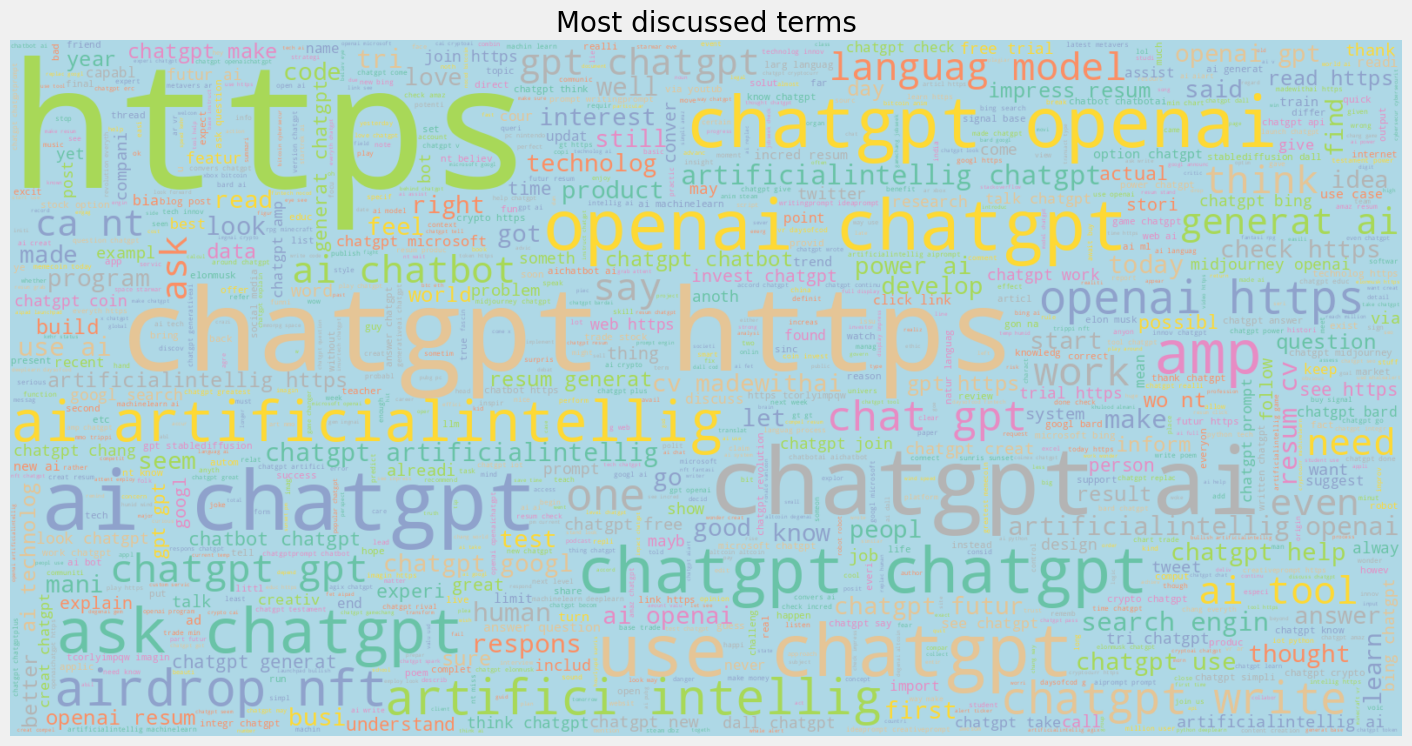

In [ ]:
# The wordcloud 
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="lightblue", colormap='Set2', max_words=1000, max_font_size= 200,  width=1600, height=800)
wc.generate(" ".join(ls))
plt.title("Most discussed terms", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Set2' , random_state=17), alpha=0.98, interpolation="bilinear", )
plt.axis('off')

#Features

In [ ]:
#not working
#most_pop = df.sort_values
#('user_followers', ascending = False)[['user_name', 'user_followers']].head(12)most_pop['user_followers1'] = most_pop['user_followers']/1000

#Changing to username

In [ ]:
#not working
#most_pop = df.sort_values('user_followers', ascending =False)[['user_name', 'user_followers']].head(12)

#most_pop['user_followers1'] = most_pop['user_followers']/1000

In [ ]:
#plt.figure(figsize = (20,25))

#sns.barplot(data = most_pop, y = 'user_name', x = 'user_followers1', color = 'c')
#plt.xticks(fontsize=27, rotation=0)
#plt.yticks(fontsize=30, rotation=0)
#plt.xlabel('User followers in Thousands', fontsize = 21)
#plt.ylabel('')
#plt.title('Followers', fontsize = 30);

#name bar plot is not defined

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk

In [ ]:
stemmer = SnowballStemmer('english')

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
df['text'].iloc[2]

'ChatGPT'

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
doc_sample = df['text'].iloc[1]
print('original document: ')

words = []

for word in doc_sample.split(' '):
    words.append(word)
    
    
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Open', 'AI']


 tokenized and lemmatized document: 
['open']


In [ ]:
df['clean_text'] = df['clean_text'].astype(str)

In [ ]:
words = []

for i in df["clean_text"]:
        words.append(i.split(' '))

#Creating Dictionary

In [ ]:
#every unique word in text
dictionary = gensim.corpora.Dictionary(words)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 rule
1 world
2 ai
3 open
4 chatgpt
5 corner
6 chat
7 gpt
8 help
9 manual
10 autom


In [ ]:
# Filter out tokens in the dictionary by their frequency.

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

#Creating corpus

doc2bow() simply counts the number of occurrences of each distinct word, converts the word to its integer word ID and returns the result as a sparse vector.

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in words]
bow_corpus[4310]
#4310

[(13, 1),
 (47, 1),
 (92, 1),
 (207, 1),
 (264, 1),
 (493, 1),
 (996, 1),
 (1057, 1),
 (1073, 1),
 (1178, 1),
 (1223, 1),
 (1224, 1),
 (1226, 1),
 (1227, 1),
 (2595, 1),
 (3248, 1),
 (3350, 1)]

In [ ]:
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 13 ("") appears 1 time.
Word 47 ("crypto") appears 1 time.
Word 92 ("openai") appears 1 time.
Word 207 ("btc") appears 1 time.
Word 264 ("result") appears 1 time.
Word 493 ("today") appears 1 time.
Word 996 ("perform") appears 1 time.
Word 1057 ("bitcoin") appears 1 time.
Word 1073 ("top") appears 1 time.
Word 1178 ("posit") appears 1 time.
Word 1223 ("cryptomarket") appears 1 time.
Word 1224 ("cryptonew") appears 1 time.
Word 1226 ("sentiment") appears 1 time.
Word 1227 ("talki") appears 1 time.
Word 2595 ("almost") appears 1 time.
Word 3248 ("surg") appears 1 time.
Word 3350 ("stx") appears 1 time.


#TF-IDF

In [ ]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.8558903314898383), (1, 0.517157365278901)]


In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=10,
                                       id2word=dictionary,
                                       passes=2,
                                       workers=2)

#Output model

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.208*"" + 0.020*"year" + 0.016*"month" + 0.016*"gt" + 0.014*"day" + 0.013*"openai" + 0.012*"million" + 0.012*"free" + 0.009*"user" + 0.006*"took"
Topic: 1 
Words: 0.043*"crypto" + 0.037*"ai" + 0.031*"web" + 0.029*"nft" + 0.026*"bitcoin" + 0.022*"eth" + 0.021*"futur" + 0.018*"btc" + 0.016*"airdrop" + 0.016*"giveaway"
Topic: 2 
Words: 0.032*"openai" + 0.025*"code" + 0.015*"program" + 0.012*"ai" + 0.012*"develop" + 0.010*"someon" + 0.009*"use" + 0.008*"app" + 0.007*"email" + 0.007*"secur"
Topic: 3 
Words: 0.032*"ai" + 0.030*"search" + 0.021*"openai" + 0.020*"googl" + 0.019*"engin" + 0.018*"impress" + 0.015*"generat" + 0.013*"see" + 0.012*"use" + 0.010*"amaz"
Topic: 4 
Words: 0.025*"ask" + 0.017*"nt" + 0.015*"write" + 0.014*"use" + 0.013*"like" + 0.012*"answer" + 0.011*"question" + 0.010*"think" + 0.010*"tri" + 0.009*"know"
Topic: 5 
Words: 0.038*"ai" + 0.018*"educ" + 0.017*"openai" + 0.015*"student" + 0.015*"use" + 0.015*"amp" + 0.012*"join" + 0.012*"imagin" + 0.012*"wri

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,
                                             num_topics=10,
                                             id2word=dictionary,
                                             passes=2,
                                             workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.009*"use" + 0.006*"ai" + 0.006*"write" + 0.005*"help" + 0.004*"ask" + 0.004*"openai" + 0.004*"languag" + 0.004*"question" + 0.004*"like" + 0.004*"tool"
Topic: 1 Word: 0.026*"airdrop" + 0.025*"nft" + 0.017*"crypto" + 0.016*"christma" + 0.016*"futur" + 0.011*"everyth" + 0.011*"invest" + 0.010*"magic" + 0.009*"ape" + 0.009*"doge"
Topic: 2 Word: 0.007*"ask" + 0.007*"nt" + 0.006*"" + 0.006*"use" + 0.005*"like" + 0.005*"tri" + 0.005*"openai" + 0.005*"answer" + 0.005*"ai" + 0.005*"question"
Topic: 3 Word: 0.010*"ai" + 0.010*"microsoft" + 0.009*"googl" + 0.008*"search" + 0.007*"bing" + 0.007*"openai" + 0.007*"educ" + 0.007*"new" + 0.006*"technolog" + 0.006*"chatbot"
Topic: 4 Word: 0.008*"ai" + 0.008*"use" + 0.008*"openai" + 0.006*"learn" + 0.006*"gpt" + 0.006*"model" + 0.005*"languag" + 0.005*"" + 0.005*"code" + 0.004*"develop"
Topic: 5 Word: 0.011*"midjourney" + 0.010*"write" + 0.010*"openai" + 0.010*"dall" + 0.009*"imagin" + 0.008*"stablediffusion" + 0.008*"gpt" + 0.008*"tco

#ChatGPT

In [ ]:
#39049th row, 2nd column 

df.iloc[39049,1]

"#OpenAI's in transition 🤖, but it's still producing amazing products like #ChatGPT💪 making it worth it. Here are some of the best open-source software options to explore  #Shotcut, #LibreOffice, #MozillaThunderbird, #MozillaFirefox, #VLCMediaPlayer, #GIMP, #Linux, &amp; #WordPress. https //t.co/OVsJ4uNvhQ"

In [ ]:
#Code by Leon Wolber https://www.kaggle.com/leonwolber/reddit-nlp-topic-modeling-prediction

unseen_document = 'so happy for the chatGPT team for com8ng up with such a revolutionary idea.The FUTURE LOOKS BRIGHT.'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.4905383884906769	 Topic: 0.025*"ask" + 0.017*"nt" + 0.015*"write" + 0.014*"use" + 0.013*"like"
Score: 0.40940454602241516	 Topic: 0.096*"ai" + 0.024*"technolog" + 0.024*"artificialintellig" + 0.024*"intellig" + 0.023*"openai"
Score: 0.012512746267020702	 Topic: 0.032*"openai" + 0.025*"code" + 0.015*"program" + 0.012*"ai" + 0.012*"develop"
Score: 0.012508811429142952	 Topic: 0.043*"crypto" + 0.037*"ai" + 0.031*"web" + 0.029*"nft" + 0.026*"bitcoin"
Score: 0.012507845647633076	 Topic: 0.032*"ai" + 0.025*"use" + 0.015*"model" + 0.014*"languag" + 0.013*"generat"
Score: 0.012507451698184013	 Topic: 0.038*"ai" + 0.018*"educ" + 0.017*"openai" + 0.015*"student" + 0.015*"use"
Score: 0.012506972998380661	 Topic: 0.032*"ai" + 0.030*"search" + 0.021*"openai" + 0.020*"googl" + 0.019*"engin"
Score: 0.012506428174674511	 Topic: 0.072*"openai" + 0.070*"ai" + 0.060*"googl" + 0.057*"gpt" + 0.034*"chat"
Score: 0.012503501027822495	 Topic: 0.208*"" + 0.020*"year" + 0.016*"month" + 0.016*"gt" + 0.0

In [ ]:
# Plot number of tweets I have the most.

plt.bar(dates, tweets.followers, figure=plt.figure(figsize=(10,6)), width=0.4);
plt.ylim(1.35e3, 1.48e3);
plt.title('Most tweets overtime');